In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from gflownet.gflownet import GFlowNet
from policy import ForwardPolicy, BackwardPolicy
from setGenerationEnv import SetGenerationEnv
from gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size = 4
nActions = 15
losses = []
rewards = []
flows = []


def train(batch_size, num_epochs):
    setEnv = SetGenerationEnv(size, nActions)
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=32, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 0.1},
    ],
    lr=5e-4)
    
    for i in (p := tqdm(range(num_epochs))):
        s0 = torch.zeros(batch_size, size).float()
        s, log, traj_length = model.sample_states(s0, return_log=True)
      

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)
        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f} T.L : {traj_length}")

    return model, losses, rewards, flows

batch_size = 512
num_epochs = 1000

model, losses, rewards, flows = train(batch_size, num_epochs)

0.180 T.L : 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.32it/s]


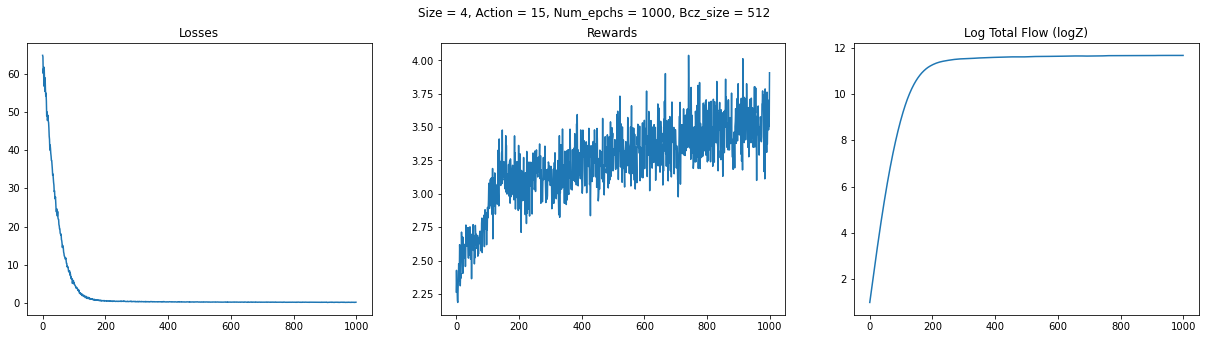

In [25]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(rewards)
ax[1].set_title("Rewards")
ax[2].plot(flows)
ax[2].set_title("Log Total Flow (logZ)")

plt.suptitle(f"Size = {size}, Action = {nActions}, Num_epchs = {num_epochs}, Bcz_size = {batch_size}")
plt.savefig("figs/result.png")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.79it/s]


torch.Size([1036800, 4])


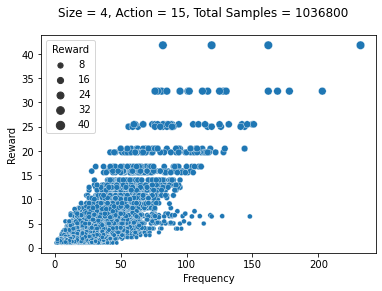

In [29]:
setEnv = SetGenerationEnv(size, nActions)
nIter = 50
terminalStates = []
for i in tqdm(range(nIter)):
    s0 = torch.zeros(12**4, size).float()
    s, traj_length = model.sample_states(s0, return_log=False)
    terminalStates.append(s)
    
s = torch.concat(terminalStates)
print(s.shape)

import seaborn as sns
import pandas as pd

setEnv = SetGenerationEnv(size, nActions)

statesForPlot = setEnv.getStateForm(s).tolist()
rewardsForPlot = setEnv.reward(s).tolist()


stateDict = {}
for i in range(len(statesForPlot)):
    state = str(statesForPlot[i])
    if state in stateDict:
        reward, freq = stateDict[state]
        stateDict[state] = (reward, freq + 1)
    else:
        stateDict[state] = (rewardsForPlot[i], 1)

allRewards = []
freqs = []
for _ in stateDict:
    reward, freq = stateDict[_]
    allRewards.append(reward)
    freqs.append(freq)

# plt.xlim(0, 150)

sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':allRewards}), x='Frequency', y='Reward', size='Reward')
plt.suptitle(f"Size = {size}, Action = {nActions}, Total Samples = {nIter * (12**4)}")
plt.savefig("figs/distribution.png")

In [28]:
for _ in stateDict:
    reward, freq = stateDict[_]
    if reward > 40:
        print(reward, _, freq)

41.81392288208008 [15.0, 1.0, 15.0, 1.0] 263
41.81392288208008 [1.0, 15.0, 15.0, 1.0] 135
41.81392288208008 [1.0, 15.0, 1.0, 15.0] 148
41.81392288208008 [15.0, 1.0, 1.0, 15.0] 107


[0.12386319041252136,
 0.10984335839748383,
 0.23995228111743927,
 0.12748824059963226,
 0.10702517628669739,
 0.2172667682170868,
 0.13683617115020752,
 0.1589946746826172,
 0.5557060241699219,
 nan]